### Utility to plot and compare truth and predicted label

This is really try to figure out what wrong. So focus on label checking. Not data processing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import matplotlib.patches as mpatches

In [2]:
proj_w=480
proj_h=48
# Read the file into pcd and reshape as (proj_h, proj_w, 10)
pcd = np.fromfile('../sequences/08/preprocess_mini/000300.bin', dtype=np.float32).reshape(proj_h, proj_w, 10)
# For Waymo dataset
# proj_w=2650
# proj_h=64
# # Read the file into pcd and reshape as (proj_h, proj_w, 10)
# pcd = np.fromfile('../WoD/validation/preprocess/30779396576054160_1880_000_1900_000.bin', dtype=np.float32).reshape(proj_h, proj_w, 10)
# pcd = pcd[8:56, 1085:1565, :]  # crop to 48, 480, 10

In [3]:
mapped_class_name = {
    0: "unlabeled",
    1: "car",
    2: "bicycle",
    3: "motorcycle",
    4: "truck",
    5: "other-vehicle",
    6: "person",
    7: "bicyclist",
    8: "motorcyclist",
    9: "road",
    10: "parking",
    11: "sidewalk",
    12: "other-ground",
    13: "building",
    14: "fence",
    15: "vegetation",
    16: "trunk",
    17: "terrain",
    18: "pole",
    19: "traffic-sign"
}

In [11]:
# plot label image from proj_pointcloud, and show the corresponding class names in x and y axis
def plot_label(proj_pointcloud):
    # if the proj_pointcloud is 3D array
    if proj_pointcloud.ndim == 3:
        label_img = proj_pointcloud[..., 9]
    else:  # 2D case
        label_img = proj_pointcloud
    plt.figure(figsize=(12, 6))
    im = plt.imshow(label_img, cmap='tab20', vmin=0, vmax=19)
    plt.axis('off')
    # Show class names as colorbar tick labels
    num_classes = 20
    class_names = [mapped_class_name[i] for i in range(num_classes)]
    cbar = plt.colorbar(im, ticks=np.arange(num_classes), orientation='horizontal')
    cbar.ax.set_xticklabels(class_names, rotation=45, ha='right')
    plt.show()

# plot the range
def plot_range(proj_pointcloud):
    plt.figure(figsize=(12, 6))
    plt.imshow(proj_pointcloud[..., 0], cmap='jet')
    plt.axis('off') # do not show x and y axis
    plt.show()

# plot RGB image from proj_pointcloud
def plot_rgb(proj_pointcloud):
    plt.figure(figsize=(12, 6))
    # proj_pointcloud[..., 6:9] are r,g,b channels
    rgb = proj_pointcloud[..., 6:9]
    # Clip values to [0, 1] if normalized, else to [0, 255]
    if rgb.max() <= 1.0:
        rgb = (rgb * 255).astype(np.uint8)
    else:
        rgb = rgb.astype(np.uint8)
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()

def plot_all(proj_pointcloud, pred_label):
    label_img = proj_pointcloud[..., 9]
    range_img = proj_pointcloud[..., 0]
    rgb_img = proj_pointcloud[..., 6:9]
    num_classes = 20
    class_names = [mapped_class_name[i] for i in range(num_classes)]
    plt.figure(figsize=(18, 10))
    plt.subplots_adjust(wspace=0.1, hspace=0)
    # Ground Truth Label (left)
    plt.subplot(3, 2, 1)
    im1 = plt.imshow(label_img, cmap='tab20', vmin=0, vmax=19)
    plt.title('Ground Truth Label')
    plt.axis('off')
    # Predicted Label (right)
    # if the label_img = 0 then the pred_label should also be 0
    pred_label[label_img == 0] = 0
    plt.subplot(3, 2, 2)
    im2 = plt.imshow(pred_label, cmap='tab20', vmin=0, vmax=19)
    plt.title('Predicted Label')
    plt.axis('off')
    # Class Names (middle left)
    plt.subplot(3, 2, 3)
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in range(num_classes)]
    patch_width = 1  # Make patch smaller
    patch_height = 0.2
    for i, (name, color) in enumerate(zip(class_names, colors)):
        plt.gca().add_patch(mpatches.Rectangle((i, 0.35), patch_width, patch_height, color=color))
        plt.text(i + patch_width/2, 0.5, name, ha='center', va='center', fontsize=9, rotation=45)
    plt.xlim(0, num_classes)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.tight_layout()
    # plt.title('Class Names')
    # Difference between label_img and pred_label (middle right)
    # If they are the same, the difference should be 0, else difference should be 1
    diff = (label_img - pred_label) != 0
    plt.subplot(3, 2, 4)
    plt.imshow(diff, cmap='gray')
    plt.title('Difference between Truth and Prediction')
    plt.axis('off')
    # Range Channel (bottom left)
    plt.subplot(3, 2, 5)
    plt.imshow(range_img, cmap='jet')
    plt.title('Range Channel')
    plt.axis('off')
    # plt.colorbar()
    # RGB Channel (bottom right)
    plt.subplot(3, 2, 6)
    if rgb_img.max() <= 1.0:
        rgb_img = (rgb_img * 255).astype(np.uint8)
    else:
        rgb_img = rgb_img.astype(np.uint8)
    plt.imshow(rgb_img)
    plt.title('RGB Channel')
    plt.axis('off')
    plt.show()

In [6]:
# A quick eval with out much of dataset loading, just data by itself, also no gpu
from model.RangeViTSegmentationModel import RangeViTSegmentationModel
model = RangeViTSegmentationModel(n_classes=20, in_channels=9)
def eval_model_quick(model, data):
    model.eval()
    feats = data[:, :, :9]  # Use the first 9 channels as features
    feats = torch.tensor(feats).permute(2, 0, 1).float()  # to [C, H, W]
    feats = feats.unsqueeze(0)  # Add batch dimension [1, C, H, W]
    outputs = model(feats)
    preds = outputs.argmax(dim=1)
    return preds

In [7]:
# Load the model if you have a pre-trained one
pretrain_path = 'range_vit_segmentation_4645.pth'
if os.path.exists(pretrain_path):
    print(f"Loading pre-trained model from {pretrain_path}")
    model.load_state_dict(torch.load(pretrain_path))
pred = eval_model_quick(model, pcd)
# plot the predictions
pred = pred.squeeze(0)  # Remove batch dimension
#  make pred to be array
pred = pred.detach().cpu().numpy()

# Use torchmetrics or do manually
from torchmetrics.classification import MulticlassJaccardIndex
# create a metric and put it on gpu
metric = MulticlassJaccardIndex(num_classes=20, average=None, ignore_index=0)
labels = pcd[:,:, 9].astype(np.float32)
preds = pred.astype(np.float32)
# make labels and preds tensors
labels = torch.from_numpy(labels)
preds = torch.from_numpy(preds)

metric.reset()
metric.update(preds, labels)
ious = metric.compute()
mean_iou = torch.mean(ious[ious != 0])
print(mean_iou)

Loading pre-trained model from range_vit_segmentation_4645.pth
tensor(0.8866)


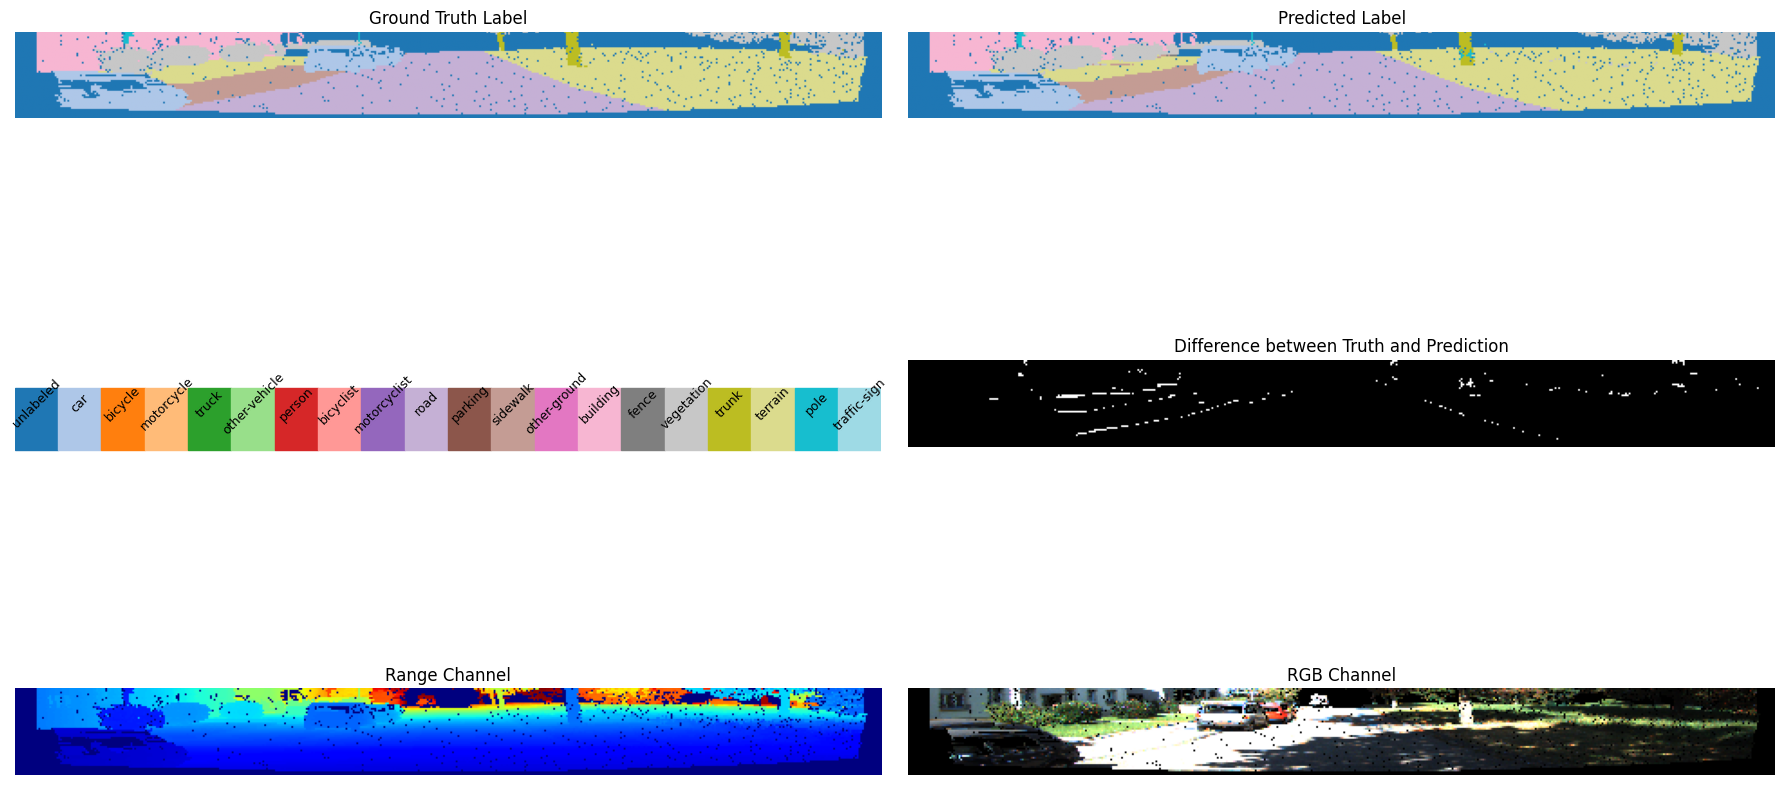

In [12]:
# plot_label(pcd)
# plot_label(pred)
# plot_range(pcd)
# plot_rgb(pcd)
plot_all(pcd, pred)